In [1]:
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout
import mdtraj as md
import matplotlib.pyplot as plt

In [2]:
# Reading in data from the pair potential table file

In [3]:
pdb = PDBFile('water512_CG.pdb')
table_file = '1_1_bumper.table'

coordinates_in_angstroms = pdb.positions
coordinates_in_nanometers = coordinates_in_angstroms / 10.0

energies = []  # energy values
distances = []  # distance values

with open(table_file, 'r') as file:
    for _ in range(5):
        next(file)

    for line in file:
        columns = line.split()

        distance = float(columns[1])
        energy = float(columns[2])
        distance = distance #*0.1   # converts to nm
        energy = energy #*4.184     # converts to kJ/mol

        distances.append(distance)
        energies.append(energy)

In [4]:
# Create an OpenMM System
system = openmm.System()

box_size = 2.5022 * nanometers
#box_size = 3.0 * nanometers
system.setDefaultPeriodicBoxVectors([box_size, 0, 0], [0, box_size, 0], [0, 0, box_size])

In [5]:
# Define the non-bonded forces (tabulated function)

tabulated_function = openmm.Continuous1DFunction(energies, 0.0, 1.0, True)

nonbond_force = openmm.CustomNonbondedForce('energy(r)')
nonbond_force.addTabulatedFunction('energy', tabulated_function)
#nonbond_force.setNonbondedMethod(openmm.CustomNonbondedForce.CutoffPeriodic)
#nonbond_force.setCutoffDistance(1.0)

charge = 0.0
for atom in pdb.topology.atoms():
    nonbond_force.addParticle()

# Add particles to the system 
for atom in pdb.topology.atoms():
    mass = 18.015400
    system.addParticle(mass)

N = system.getNumParticles()
print ("Number of particles =", N)

# Add the CustomCompoundBondForce to the System
system.addForce(nonbond_force)
print (system)

Number of particles = 512
<openmm.openmm.System; proxy of <Swig Object of type 'OpenMM::System *' at 0x148df0a6dbf0> >


In [6]:
# Molecular Dynamics

#integrator = VerletIntegrator(0.005*picoseconds)
#integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.005*picoseconds)
integrator = NoseHooverIntegrator(300*kelvin, 1/picosecond, 0.005*picoseconds, 4, 1, 1)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
#simulation.context.setPositions(coordinates_in_nanometers)
#simulation.context.setPeriodicBoxVectors([box_size, 0, 0], [0, box_size, 0], [0, 0, box_size])
simulation.minimizeEnergy()
simulation.reporters.append(DCDReporter('output.dcd', 1000))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, potentialEnergy=True, temperature=True))
#simulation.reporters.append(ForceReporter('forces.txt', 1000))

# Get the state
state = simulation.context.getState(getPositions=True, getVelocities=True, getEnergy=True, getForces=True, getParameters=True, enforcePeriodicBox=True)

# Extract the box vectors
box_vectors = state.getPeriodicBoxVectors()
print("Box Vectors:")
print(box_vectors)

# Retrieve and print the starting coordinates
state = simulation.context.getState(getPositions=True)
positions = state.getPositions()

print("Starting coordinates:")
for i, pos in enumerate(positions):
    print(f"Particle {i}: {pos}")

# Optionally, you can save the starting coordinates to a file for further inspection
with open("starting_coordinates.txt", "w") as f:
    for i, pos in enumerate(positions):
        f.write(f"Particle {i}: {pos}\n")

Box Vectors:
[Vec3(x=2.5022, y=0.0, z=0.0), Vec3(x=0.0, y=2.5022, z=0.0), Vec3(x=0.0, y=0.0, z=2.5022)] nm
Starting coordinates:
Particle 0: Vec3(x=1.8899752394363725, y=2.427521189917911, z=1.9506373879423857) nm
Particle 1: Vec3(x=0.22219381096829108, y=0.04344323500653424, z=1.9004190340160168) nm
Particle 2: Vec3(x=0.6275444477338531, y=0.8102082010194755, z=2.1671737284234167) nm
Particle 3: Vec3(x=0.9436907073157003, y=1.6591794417136636, z=1.9605874735210211) nm
Particle 4: Vec3(x=0.9791166885033028, y=2.2630986356657394, z=1.9554626779678503) nm
Particle 5: Vec3(x=1.1419042516721698, y=0.04000656400871117, z=2.341614210762836) nm
Particle 6: Vec3(x=2.295815488803567, y=1.42757807615366, z=0.8792783324186826) nm
Particle 7: Vec3(x=1.5760531944261582, y=0.016204029749813057, z=1.6119840732451003) nm
Particle 8: Vec3(x=0.6456223202396628, y=0.8502256352585326, z=1.9639896678599185) nm
Particle 9: Vec3(x=0.4127841060395308, y=0.5338137371795134, z=2.0413702042411477) nm
Particle 10

In [7]:
simulation.step(5000)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,1785675.9897460938,3466025033.357938
2000,1784999.9338989258,7986286886.029257
3000,1802695.462463379,11030523826.177366
4000,1763744.9895935059,14190584324.979914
5000,1789637.556060791,17506237518.02477


In [8]:
# Print system characteristics
def print_system_info(system):
    print("Number of particles:", system.getNumParticles())
    print("Number of constraints:", system.getNumConstraints())
    print("Number of forces:", system.getNumForces())

    for i in range(system.getNumForces()):
        force = system.getForce(i)
        print(f"\nForce {i}: {type(force).__name__}")
        
        if isinstance(force, CustomNonbondedForce):
            print("  Energy function:", force.getEnergyFunction())
            print("  Number of particles:", force.getNumParticles())
            print("  Number of exclusions:", force.getNumExclusions())
            print("  Nonbonded method:", force.getNonbondedMethod())
            print("  Cutoff distance (nm):", force.getCutoffDistance().value_in_unit(nanometers))
            for j in range(force.getNumTabulatedFunctions()):
                func = force.getTabulatedFunction(j)
                print(f"  Tabulated function {j}: {type(func).__name__}")

# Call the function to print the system info
print_system_info(system)

Number of particles: 512
Number of constraints: 0
Number of forces: 1

Force 0: CustomNonbondedForce
  Energy function: energy(r)
  Number of particles: 512
  Number of exclusions: 0
  Nonbonded method: 0
  Cutoff distance (nm): 1.0
  Tabulated function 0: Continuous1DFunction


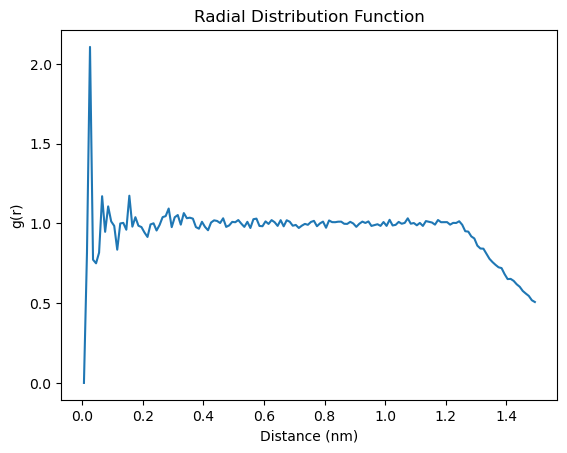

In [9]:
# Load the trajectory
traj = md.load('output.dcd', top='water512_CG.pdb')

# Define atom pairs for which to compute the RDF (all the CG beads here)
oxygen_atoms = traj.topology.select('name O')

# Compute RDF
rdf, r = md.compute_rdf(traj, pairs=traj.topology.select_pairs(oxygen_atoms, oxygen_atoms), r_range=(0.0, 1.5), bin_width=0.01)

# Plot RDF
plt.plot(rdf, r)
plt.xlabel('Distance (nm)')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function')
plt.show()